In [2710]:
import pandas as pd

# classification dataset for voting ensemble
classification_data = pd.read_csv("./classification_data_cleaned.csv")
# regression dataset for decision tree models 
regression_data = pd.read_csv("./regression_data_cleaned.csv")


In [2711]:
# prepare data for classification
from sklearn.model_selection import train_test_split

# Features and target
x_clf = classification_data.drop(columns=["Mortality_Status"])
y_clf = classification_data["Mortality_Status"]

# Train-test split
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(
    x_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# inspect and encode
print(x_train_clf.dtypes[x_train_clf.dtypes == 'object'])




6th_Stage         object
Differentiated    object
A_Stage           object
dtype: object


In [2712]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd


# Step 1: One-hot encode the 3 object columns
x_train_clf = pd.get_dummies(x_train_clf, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)
x_test_clf = pd.get_dummies(x_test_clf, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)


# Step 2: Align the test set to have the same columns as train set
x_train_clf, x_test_clf = x_train_clf.align(x_test_clf, join='left', axis=1, fill_value=0)

imputer = SimpleImputer(strategy='median')
x_train_clf = imputer.fit_transform(x_train_clf)
x_test_clf = imputer.transform(x_test_clf)

# Step 3: Standardize the features
scaler = StandardScaler()
x_train_clf_scaled = scaler.fit_transform(x_train_clf)
x_test_clf_scaled = scaler.transform(x_test_clf)


In [2713]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Create base models
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)

# Ensemble: Voting
voting_clf = VotingClassifier(
    estimators=[("lr", lr), ("knn", knn)],
    voting='soft' 
)

voting_clf.fit(x_train_clf_scaled, y_train_clf)


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [2714]:
# re-usable confusion metrics function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, x_test, y_test, model_name="Model", cmap='Blues'):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=cmap)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


In [2715]:
# re-useable function for classification report
from sklearn.metrics import classification_report

def print_classification_report(model, x_test, y_test, model_name="Model"):
    y_pred = model.predict(x_test)
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_test, y_pred))

In [2716]:
# re-usable roc-curve function
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# custom ROC Curve 
def plot_custom_roc_curve(model, x_test, y_test, model_name="Model"):
    y_probs = model.predict_proba(x_test)[:, 1]
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize=(6, 4))
    plt.plot(false_positive_rate, true_positive_rate, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [2717]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(x_train_clf_scaled, y_train_clf)

KNeighborsClassifier()

In [2718]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(x_train_clf_scaled, y_train_clf)


LogisticRegression(max_iter=5000)

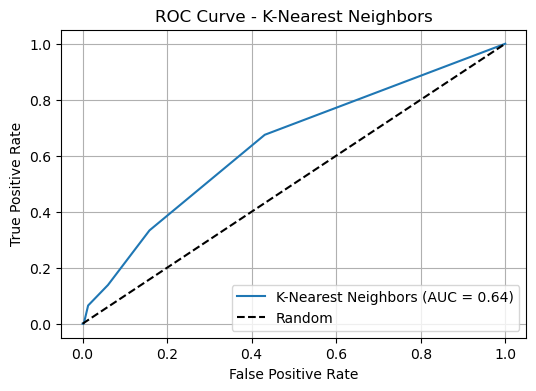

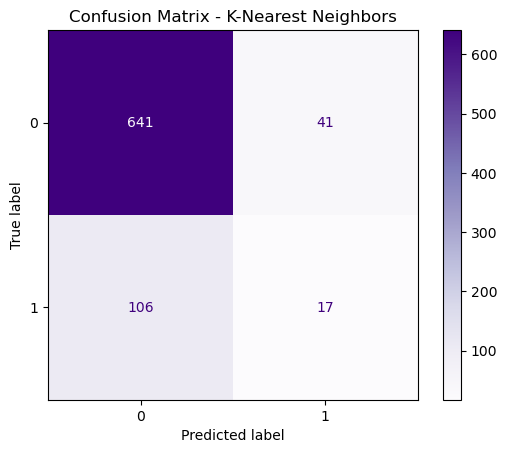


Classification Report - K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       682
           1       0.29      0.14      0.19       123

    accuracy                           0.82       805
   macro avg       0.58      0.54      0.54       805
weighted avg       0.77      0.82      0.79       805



In [2719]:
plot_custom_roc_curve(knn_model, x_test_clf_scaled, y_test_clf, "K-Nearest Neighbors")
plot_confusion_matrix(knn_model, x_test_clf_scaled, y_test_clf, model_name="K-Nearest Neighbors", cmap='Purples')
print_classification_report(knn_model, x_test_clf_scaled, y_test_clf, model_name="K-Nearest Neighbors")


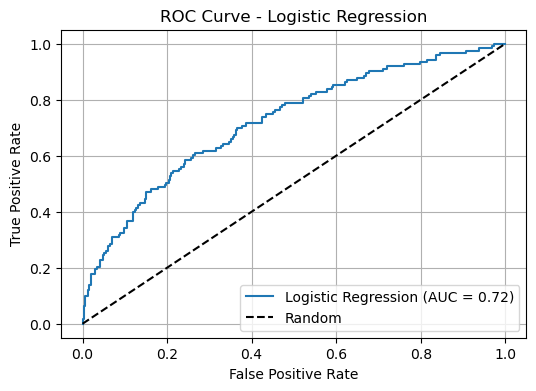

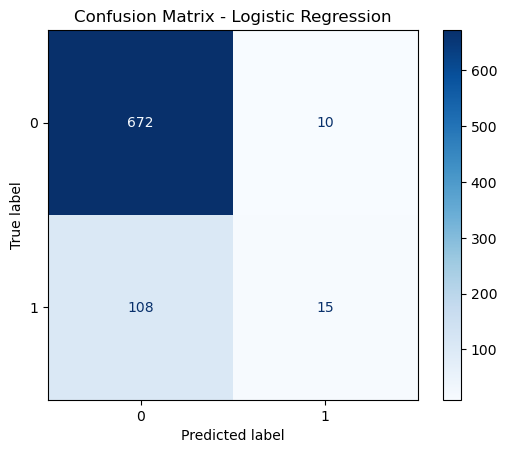


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       682
           1       0.60      0.12      0.20       123

    accuracy                           0.85       805
   macro avg       0.73      0.55      0.56       805
weighted avg       0.82      0.85      0.81       805



In [2720]:
plot_custom_roc_curve(lr_model, x_test_clf_scaled, y_test_clf, "Logistic Regression")
plot_confusion_matrix(lr_model, x_test_clf_scaled, y_test_clf, model_name="Logistic Regression")
print_classification_report(lr_model, x_test_clf_scaled, y_test_clf, model_name="Logistic Regression")

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       682
           1       0.43      0.12      0.19       123

    accuracy                           0.84       805
   macro avg       0.64      0.55      0.55       805
weighted avg       0.79      0.84      0.80       805

AUC Score: 0.7009989747991321


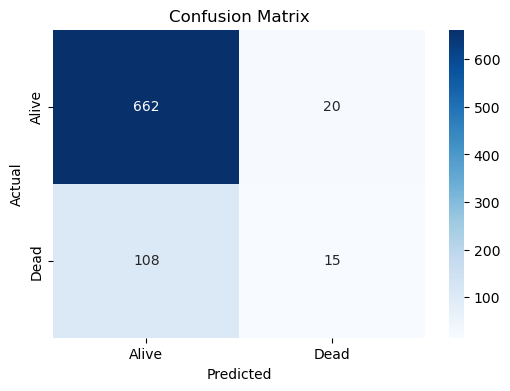

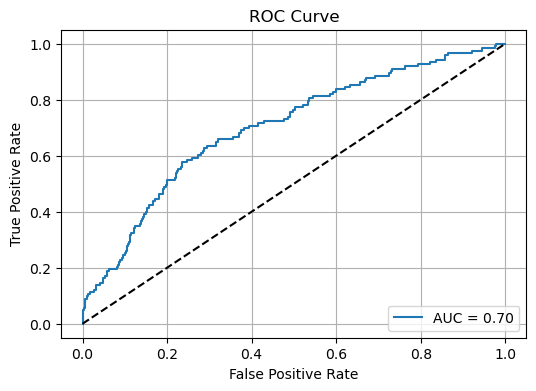

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Predictions and probabilities
y_pred = voting_clf.predict(x_test_clf_scaled)
y_probs = voting_clf.predict_proba(x_test_clf_scaled)[:, 1]

# Classification report and AUC score
print("Classification Report:\n", classification_report(y_test_clf, y_pred))
print("AUC Score:", roc_auc_score(y_test_clf, y_probs))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Alive", "Dead"], yticklabels=["Alive", "Dead"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_clf, y_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_clf, y_probs):.2f}")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [2722]:
# Display shape and feature names
print("Dataset Dimensions (rows, columns):", regression_data.shape)
print("\nFeature Names:")
for col in regression_data.columns:
    print(col)


Dataset Dimensions (rows, columns): (616, 17)

Feature Names:
Age
6th_Stage
Differentiated
Grade
A_Stage
Tumor_Size
Regional_Node_Examined
Reginol_Node_Positive
Survival_Months
Mortality_Status
T_Stage_T2
T_Stage_T3
T_Stage_T4
N_Stage_N2
N_Stage_N3
Estrogen_Status_Positive
Progesterone_Status_Positive


In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# Separate features and target
x = regression_data.drop(columns=['Survival_Months'])  
y = regression_data['Survival_Months']

# Identify categorical columns
categorical_cols = x.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  
)

x_encoded = preprocessor.fit_transform(x)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)


In [2724]:
# -------------------------------
# DT-1: Default decision tree
# -------------------------------
dt1 = DecisionTreeRegressor(random_state=42)
dt1.fit(x_train, y_train)


DecisionTreeRegressor(random_state=42)

In [2725]:
y_pred_dt1 = dt1.predict(x_test)

print("DT-1 (Default) Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_dt1))
print("MSE:", mean_squared_error(y_test, y_pred_dt1))
print("R²:", r2_score(y_test, y_pred_dt1))


DT-1 (Default) Performance:
MAE: 25.032258064516128
MSE: 1157.032258064516
R²: -1.1064768154710038


In [2726]:
# -------------------------------
# DT-2: Tuned decision tree
# -------------------------------
dt2 = DecisionTreeRegressor(max_depth=5, min_samples_split=100, random_state=42)
dt2.fit(x_train, y_train)




DecisionTreeRegressor(max_depth=5, min_samples_split=100, random_state=42)

In [2727]:
y_pred_dt2 = dt2.predict(x_test)

print("\nDT-2 (Tuned) Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_dt2))
print("MSE:", mean_squared_error(y_test, y_pred_dt2))
print("R²:", r2_score(y_test, y_pred_dt2))


DT-2 (Tuned) Performance:
MAE: 18.029239373649826
MSE: 534.1962831577341
R²: 0.027449686437519216


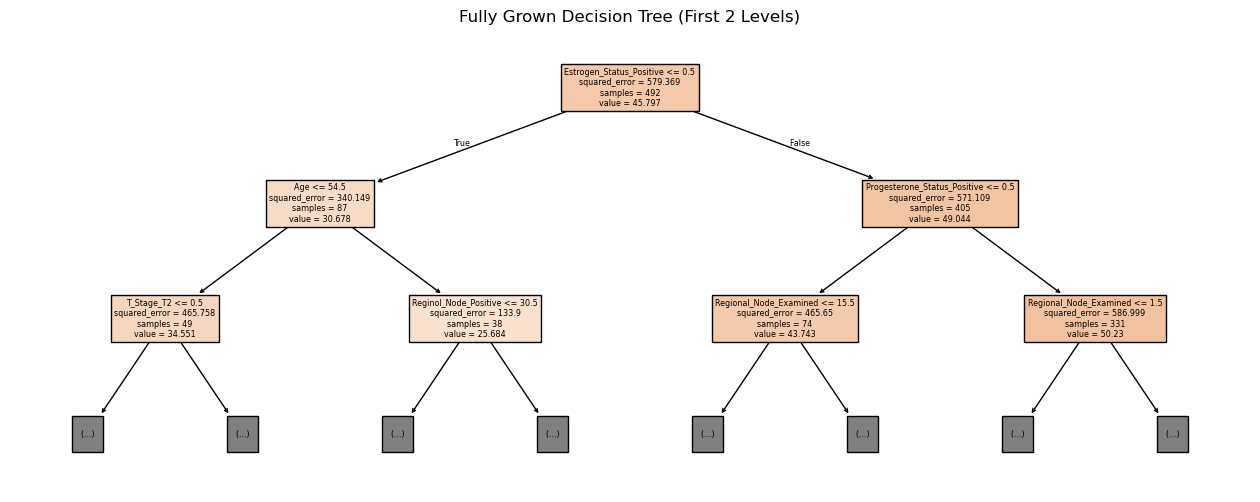

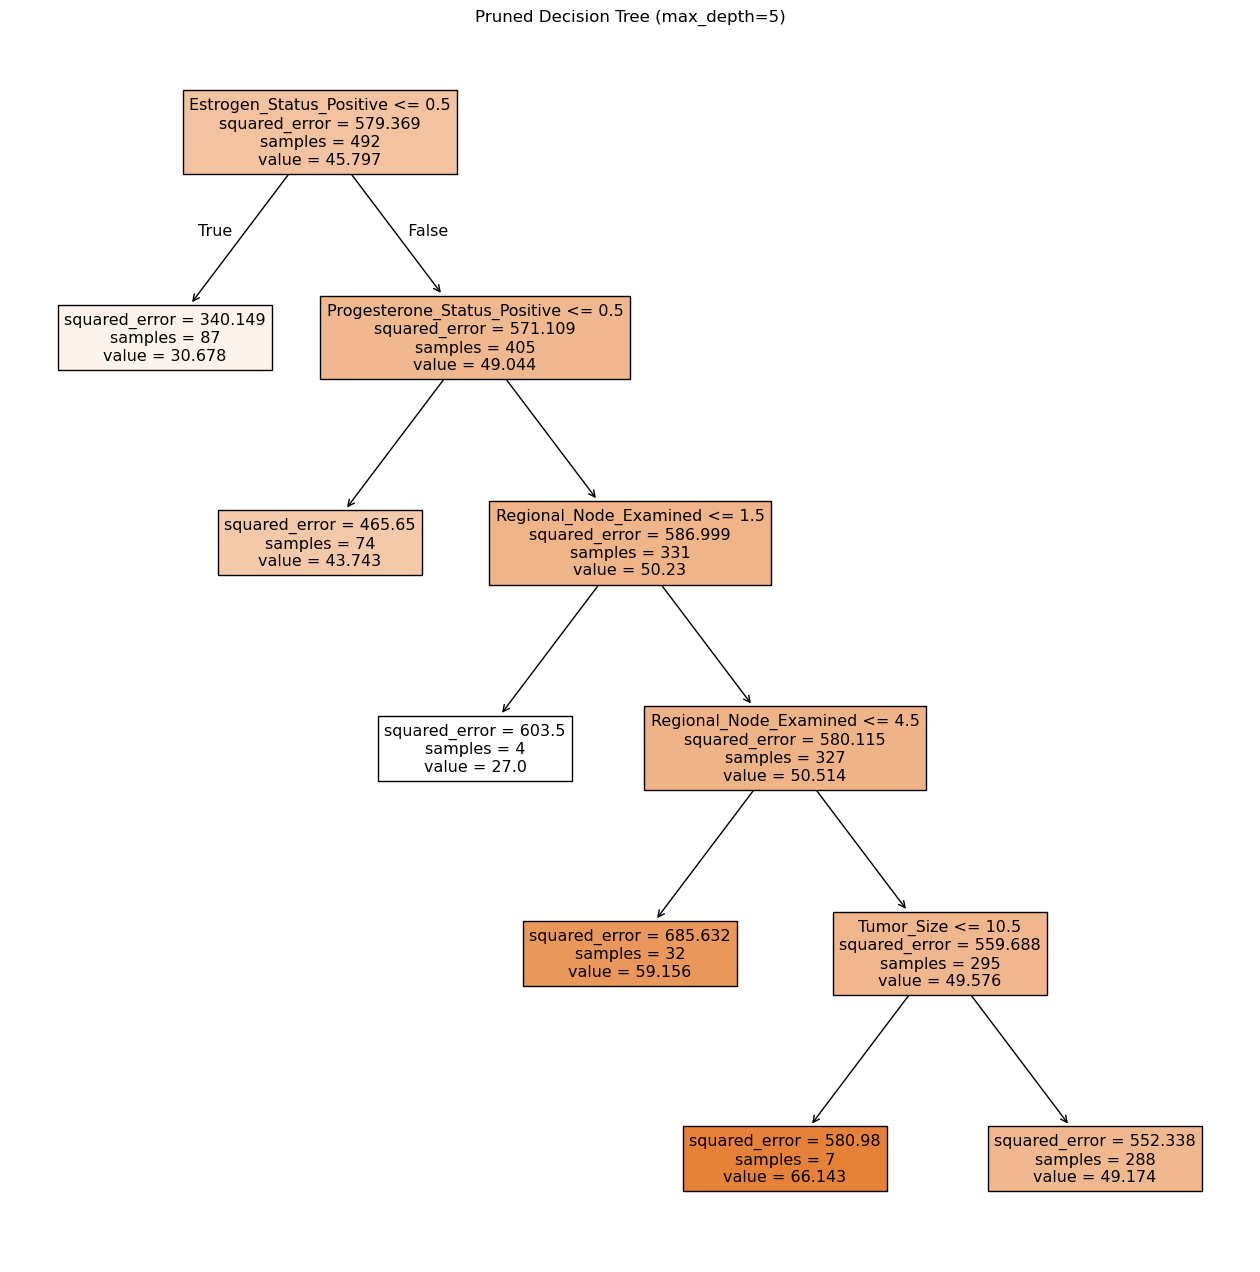

In [2728]:

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get feature names after encoding
# This part gets the names from the OneHotEncoder and other columns
ohe = preprocessor.named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_cols)

# Get numeric columns (those not encoded)
numeric_cols = [col for col in x.columns if col not in categorical_cols]

# Combine encoded categorical and numeric columns
feature_names = list(encoded_cat_features) + numeric_cols

# Visualize DT-1: fully grown (first 2 levels)
plt.figure(figsize=(16, 6))
plot_tree(dt1, filled=True, max_depth=2, feature_names=feature_names)
plt.title("Fully Grown Decision Tree (First 2 Levels)")
plt.show()

# Visualize DT-2: pruned tree
plt.figure(figsize=(16, 16))
plot_tree(dt2, filled=True, feature_names=feature_names)
plt.title("Pruned Decision Tree (max_depth=5)")
plt.show()


In [2729]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree



patient_data = {feature: 0 for feature in feature_names_1}

# Create a single-row DataFrame with the patient's information
patient_data.update({
    'AGE': 29,
    'TUMOR_SIZE': 41,
    'GRADE': 2,
    'REGIONAL_NODE_EXAMINED': 5,
    'REGIONAL_NODE_POSITIVE': 1,
    'SEX_Female': 1,
    'ESTROGEN_STATUS_Negative': 1,
    'PROGESTERONE_STATUS_Positive': 1,
    'OCCUPATION_CODE': 15,
    'T_STAGE_T3': 1,
    'N_STAGE_N1': 1,
    'STAGE_6_IIIC': 1,
    'DIFFERENTIATED_Moderately differentiated': 1,
    'A_STAGE_Regional': 1
})

In [2730]:
# Create DataFrame for prediction
patient_input = pd.DataFrame([patient_data])

# Ensure the same number of features as the model (align with one-hot encoded features)
patient_input = patient_input.reindex(columns=feature_names, fill_value=0)

# Predict with the trained model (dt2)
prediction = dt2.predict(patient_input)[0]

# Apply same dummy encoding as on training data
patient_encoded = pd.get_dummies(patient_data)

# Align the columns with training data
patient_encoded = patient_encoded.reindex(columns=x_train_columns, fill_value=0)



print(f"\n✅ Predicted survival months for patient B002565: {prediction:.2f} months\n")



✅ Predicted survival months for patient B002565: 30.68 months



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [2731]:
# Check the columns of the regression_data
print(regression_data.columns)


Index(['Age', '6th_Stage', 'Differentiated', 'Grade', 'A_Stage', 'Tumor_Size',
       'Regional_Node_Examined', 'Reginol_Node_Positive', 'Survival_Months',
       'Mortality_Status', 'T_Stage_T2', 'T_Stage_T3', 'T_Stage_T4',
       'N_Stage_N2', 'N_Stage_N3', 'Estrogen_Status_Positive',
       'Progesterone_Status_Positive'],
      dtype='object')


DT1 Performance on Test Set:
Mean Absolute Error: 26.217741935483872
Mean Squared Error: 1190.5887096774193
R² Score: -1.1675692239491378
Depth of DT1: 28


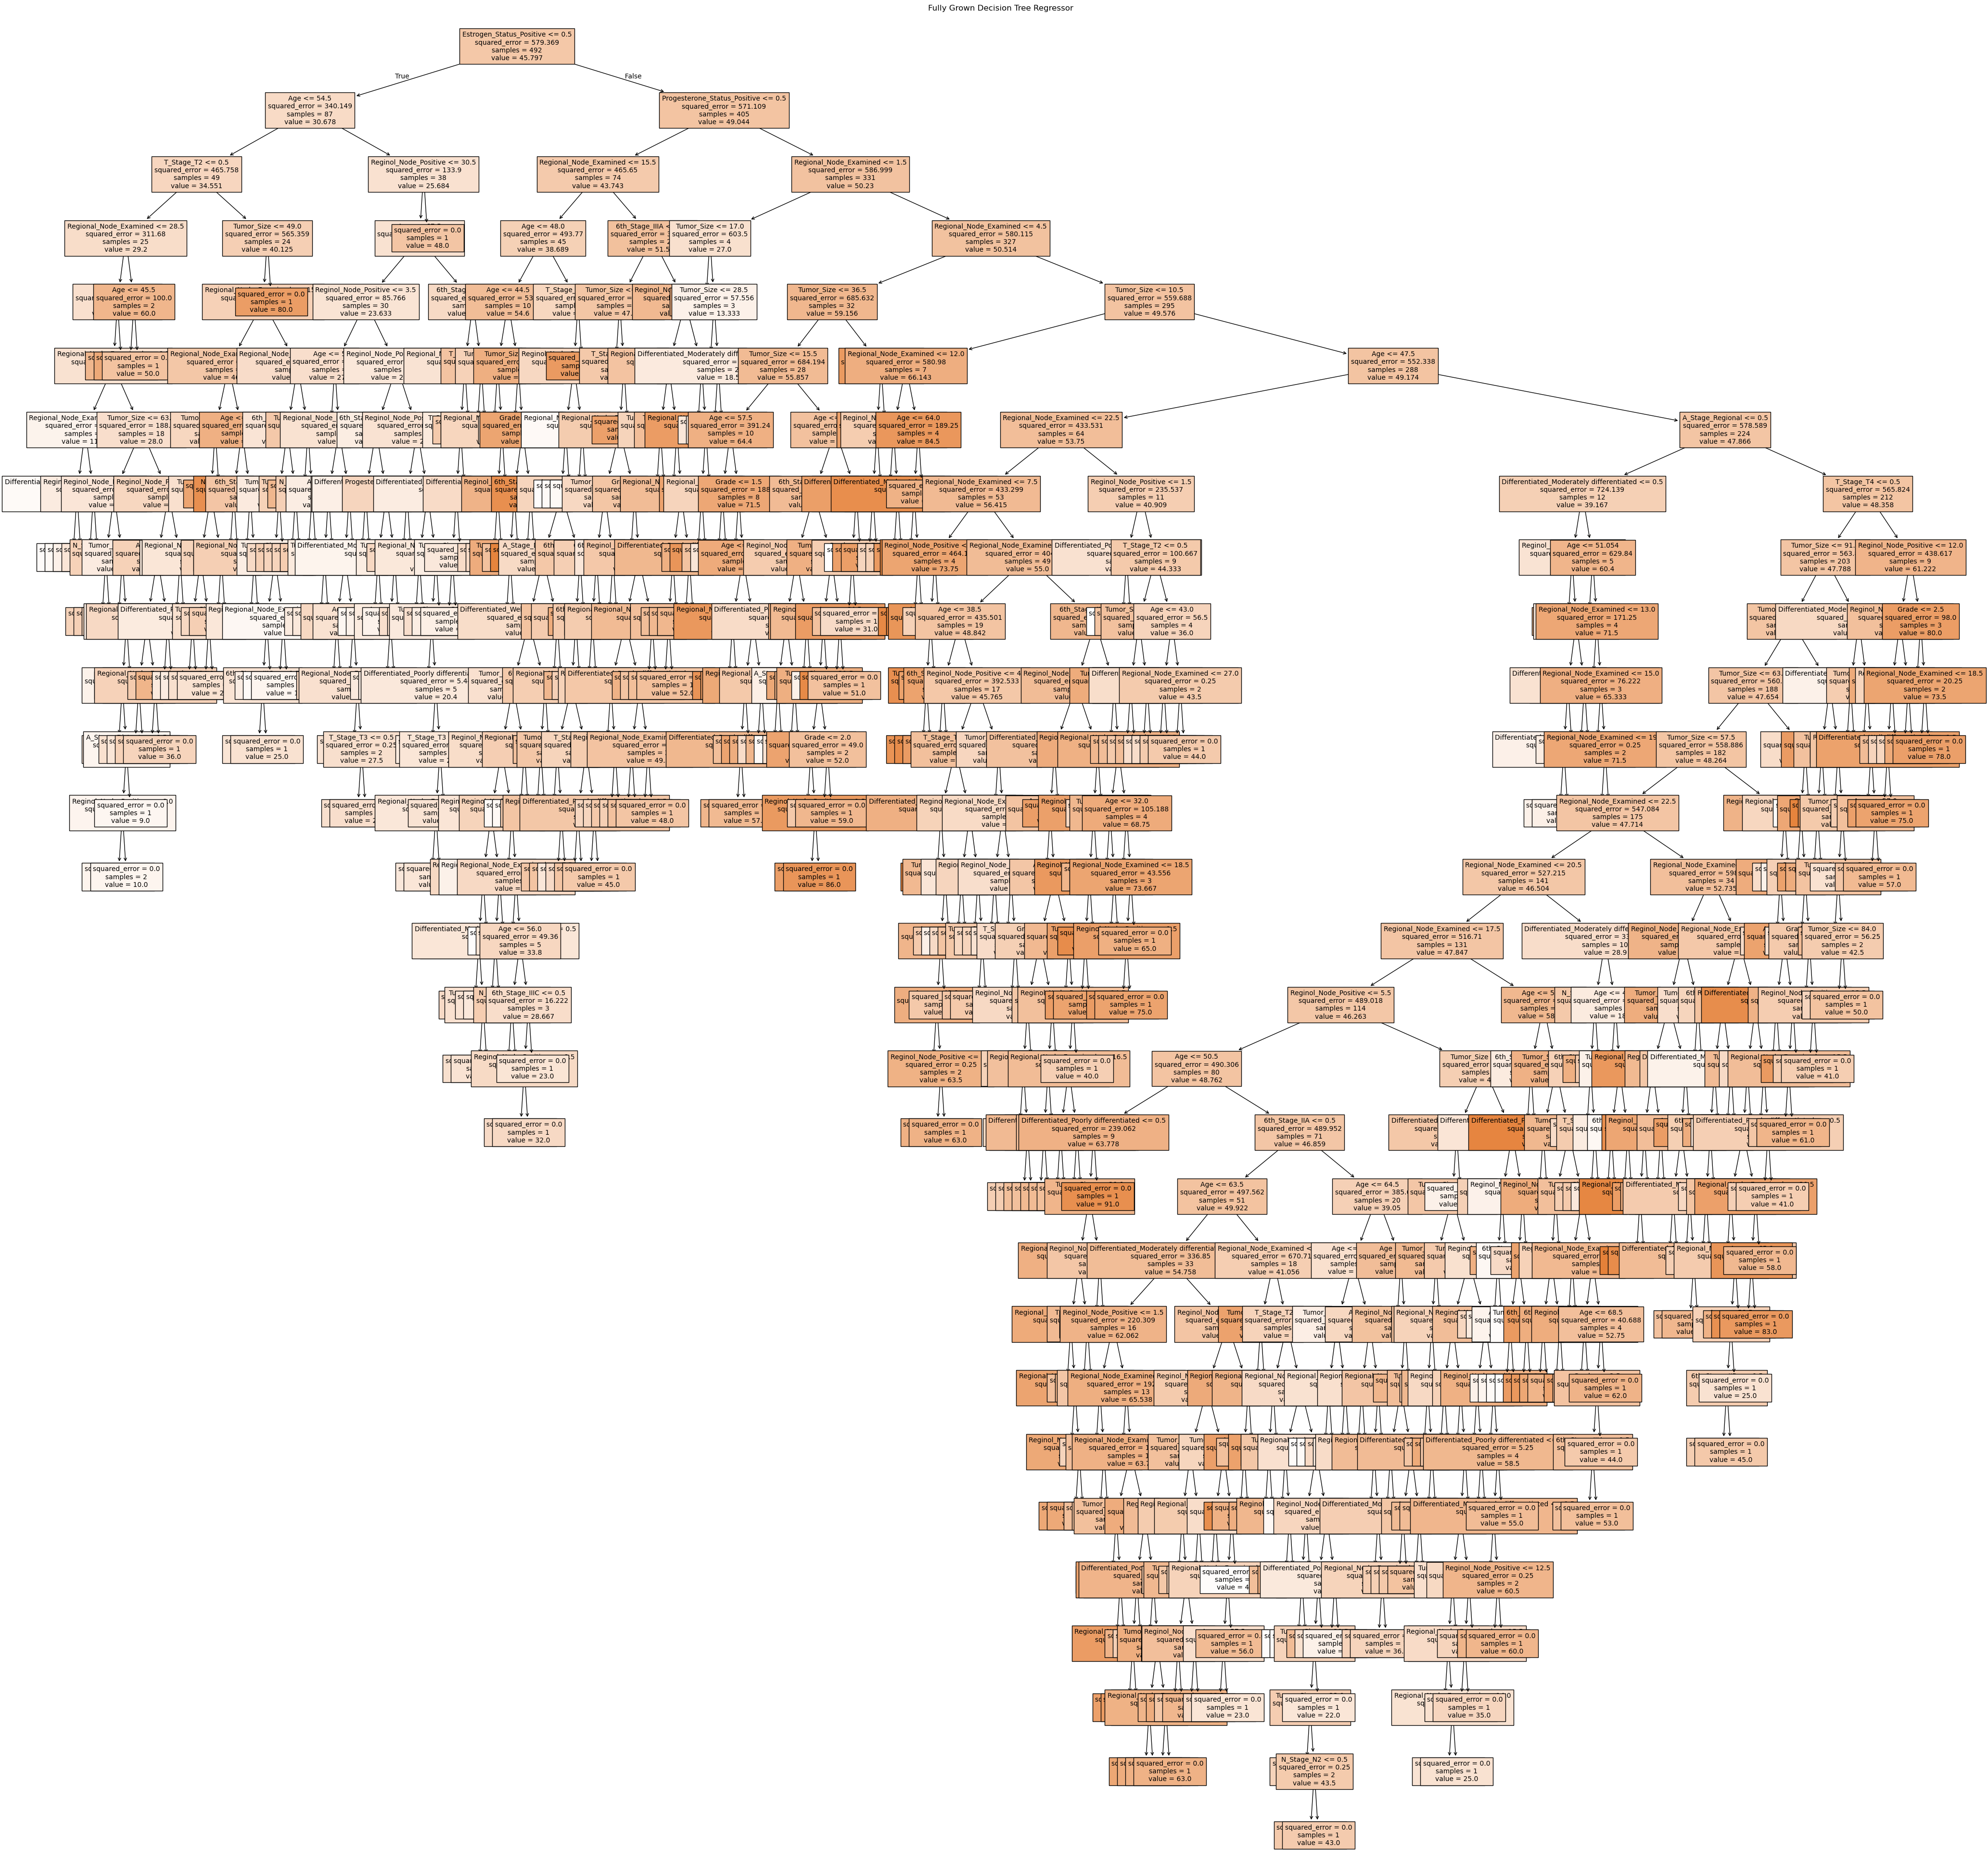

In [2732]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Instantiate and train a fully-grown decision tree regressor
dt_reg_full = DecisionTreeRegressor()
dt_reg_full.fit(x_train, y_train)

# Predict on the test set
yr_pred_full = dt_reg_full.predict(x_test)

# Evaluate the fully-grown tree model
print("DT1 Performance on Test Set:")
print("Mean Absolute Error:", mean_absolute_error(y_test, yr_pred_full))
print("Mean Squared Error:", mean_squared_error(y_test, yr_pred_full))
print("R² Score:", r2_score(y_test, yr_pred_full))

# Print the depth of the fully grown tree
print("Depth of DT1:", dt_reg_full.tree_.max_depth)

# Get feature names from the encoder
encoder = preprocessor.named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(categorical_cols)
non_cat_features = [col for col in x.columns if col not in categorical_cols]
all_feature_names = np.concatenate([encoded_cat_features, non_cat_features])

# Plot the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dt_reg_full, feature_names=all_feature_names, filled=True, fontsize=10)
plt.title("Fully Grown Decision Tree Regressor")
plt.savefig("full_decision_tree_regressor.png")
plt.show()